# DEA Coastlines useful tools <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This notebook contains useful code snippets for processing and manipulating DEA Coastlines data.


---

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-coastlines


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [2]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


## Extract style table from GeoPackage

In [ ]:
import zipfile
with zipfile.ZipFile('../coastlines_v0.2.2.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
# Load 'layer_styles' from geopackage and export as a CSV
layer = gpd.read_file("coastlines_v0.0.2 (1).gpkg", layer="layer_styles")
layer.drop(['geometry'], axis=1).to_csv('coastlines/styles.csv', index=False)

## View output files on S3

In [ ]:
# !aws s3 --no-sign-request --region=af-south-1 ls --recursive s3://deafrica-data-dev-af/coastlines/ | grep '.gpkg$'

In [ ]:
# !aws s3 --no-sign-request --region=af-south-1 ls --recursive s3://deafrica-data-staging-af/coastlines/


## Run status per tile from Argo YAML

In [8]:
import pandas as pd
import yaml
from yaml import SafeLoader

# Load Argo job status
with open('run_status_30nodes_codefix.yaml') as f:
    data = yaml.load(f, Loader=SafeLoader)

# Keep only jobs with valid inputs    
data_cleaned = {a:b for a, b in data['status']['nodes'].items() if 'inputs' in b}

# Obtain error code or missing error code for each job
df = pd.DataFrame(
    [
        (b["inputs"]["parameters"][0]["value"], b["outputs"]["exitCode"], b["startedAt"], b["finishedAt"])
        if "outputs" in b
        else (b["inputs"]["parameters"][0]["value"], None)
        for a, b in data_cleaned.items()
    ],
    columns=["id", "error", "startedAt", "finishedAt"],
)

# # Drop non-tiles
df = df.loc[~df.id.isin(['v0.0.1', 'bottleneck', 'bottleneck2', 'https://dea-public-data.s3.ap-southeast-2.amazonaws.com/derivative/dea_coastlines/supplementary/ga_summary_grid_c3_32km_coastal.geojson'])]

# Calculate duration
df['id'] = df.id.astype(int)
df['startedAt'] = pd.to_datetime(df['startedAt'])
df['finishedAt'] = pd.to_datetime(df['finishedAt'])
df['duration'] = df['finishedAt'] - df['startedAt']

# Set up logical errors
df['error'] = df['error'].replace({None: 2, '1': 1, '0': 0})

# Group and combine multiple runs into one
overall_df = df.loc[df.groupby('id')['error'].idxmin()]
# overall_df['retries'] = df.groupby('id')['error'].nunique()
overall_df['duration'] = overall_df.duration.dt.seconds / 60

# Export to geoJSON
tiles_gdf = gpd.read_file('https://dea-public-data.s3.ap-southeast-2.amazonaws.com/derivative/dea_coastlines/supplementary/ga_summary_grid_c3_32km_coastal.geojson')
tiles_gdf.merge(overall_df, on='id').to_file('test.geojson')

In [14]:
import datacube

dc = datacube.Datacube()


In [20]:
dc.find_datasets(product='ga_ls9c_ard_3')

[Dataset <id=11b7d760-e889-472a-8894-b62a656b6e55 product=ga_ls9c_ard_3 location=s3://dea-public-data/baseline/ga_ls9c_ard_3/095/081/2022/04/23/ga_ls9c_ard_3-2-1_095081_2022-04-23_final.odc-metadata.yaml>,
 Dataset <id=aa173b4a-2e17-4ca6-bfa8-b286557d805f product=ga_ls9c_ard_3 location=s3://dea-public-data/baseline/ga_ls9c_ard_3/095/082/2022/04/07/ga_ls9c_ard_3-2-1_095082_2022-04-07_final.odc-metadata.yaml>,
 Dataset <id=054c4e6a-4e54-44ac-bc47-114ef72fd177 product=ga_ls9c_ard_3 location=s3://dea-public-data/baseline/ga_ls9c_ard_3/095/081/2022/01/01/ga_ls9c_ard_3-2-1_095081_2022-01-01_final.odc-metadata.yaml>,
 Dataset <id=1e7ffc5d-d3fe-435a-966d-e2f3c7dfd71a product=ga_ls9c_ard_3 location=s3://dea-public-data/baseline/ga_ls9c_ard_3/095/080/2022/09/14/ga_ls9c_ard_3-2-1_095080_2022-09-14_final.odc-metadata.yaml>,
 Dataset <id=66610a33-0282-43fa-99a7-f02a9a0d4f98 product=ga_ls9c_ard_3 location=s3://dea-public-data/baseline/ga_ls9c_ard_3/095/081/2022/01/17/ga_ls9c_ard_3-2-1_095081_2022-01

In [9]:
ids = [860, 866, 867, 872, 873, 876, 878, 881, 883, 884, 887, 888, 892, 893, 897, 902, 903, 906, 907, 910, 912, 913, 915, 917, 929, 930, 940, 952, 953, 966, 967, 968, 976, 977, 978, 986, 987, 988, 989, 995, 996, 997, 998, 999, 1005, 1006, 1007, 1008, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142, 1143, 1144, 1145, 1146, 1147, 1148, 1149, 1150, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182, 1183, 1184, 1185, 1186, 1187, 1188, 1189, 1190, 1191, 1192, 1193, 1194, 1195, 1196, 1197, 1198, 1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209, 1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220, 1222, 1223]

In [10]:
ids = ids[0:100]
# ids = [1097]

df_subset = df.loc[df.id.isin(ids)]
df_subset


,id,error,startedAt,finishedAt,duration
0,1105,0,2022-11-04 04:14:52+00:00,2022-11-04 04:49:24+00:00,0 days 00:34:32
1,1079,0,2022-11-04 04:14:51+00:00,2022-11-04 04:46:55+00:00,0 days 00:32:04
2,1008,0,2022-11-04 04:14:50+00:00,2022-11-04 04:38:12+00:00,0 days 00:23:22
3,913,0,2022-11-04 04:14:49+00:00,2022-11-04 04:34:17+00:00,0 days 00:19:28
4,1083,0,2022-11-04 04:14:51+00:00,2022-11-04 04:49:40+00:00,0 days 00:34:49
...,...,...,...,...,...
197,878,0,2022-11-04 04:14:49+00:00,2022-11-04 04:37:12+00:00,0 days 00:22:23
198,1107,0,2022-11-04 04:14:52+00:00,2022-11-04 04:48:39+00:00,0 days 00:33:47
199,952,0,2022-11-04 04:14:49+00:00,2022-11-04 04:35:37+00:00,0 days 00:20:48
200,892,0,2022-11-04 04:14:49+00:00,2022-11-04 04:34:34+00:00,0 days 00:19:45


<AxesSubplot:ylabel='Frequency'>

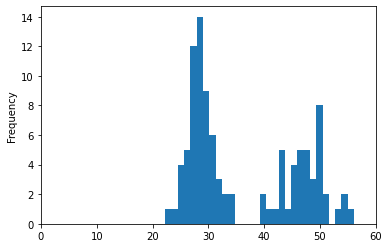

In [6]:
(df_max_nodes_30.groupby('id')['duration'].max().dt.seconds/60).plot.hist(xlim=(0, 60))

In [7]:
df_max_nodes_30.groupby('id')['duration'].max().median()

Timedelta('0 days 00:30:52')

<AxesSubplot:ylabel='Frequency'>

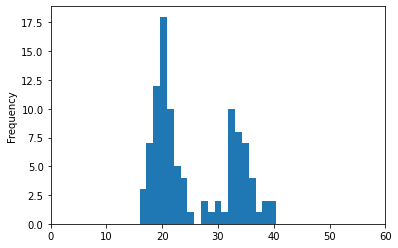

In [12]:
(df_max_nodes_30_codefix.groupby('id')['duration'].max().dt.seconds/60).plot.hist(xlim=(0, 60))

In [13]:
df_max_nodes_30_codefix.groupby('id')['duration'].max().median()

Timedelta('0 days 00:22:07.500000')

<AxesSubplot:ylabel='Frequency'>

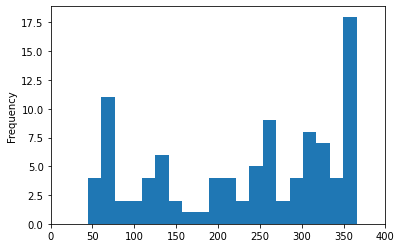

In [54]:
df_max_nodes_150 = df_subset
(df_max_nodes_150.groupby('id')['duration'].max().dt.seconds/60).plot.hist(xlim=(0, 400))

In [13]:
df_subset.groupby('id')['duration'].max().median()

Timedelta('0 days 04:15:11.500000')

In [ ]:
df_subset.duration.mean()

In [ ]:
data_cleaned['dea-coastlines-flhfc-1000208692']

In [ ]:
df['error'].unique()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/dea-coastlines/issues/new).

**Last modified:** July 2022